In [1]:
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Predicting Market price

## Approach 1

Our first approach to predict market price is to model the difference between actual and oracle's prediction for market price. After fitting the model and subsequently forecasting the difference we add it to oracle's prediction for market price to get our prediction.

### Loading series

In [2]:
price_train_actual = pd.read_csv('./Processed Data/Price_Train.csv', header=None)
price_train_oracle = pd.read_csv('./Processed Data/Price_Train_pred.csv', header=None)

In [3]:
series = (price_train_actual - price_train_oracle).values.copy().flatten()

### Plotting the series

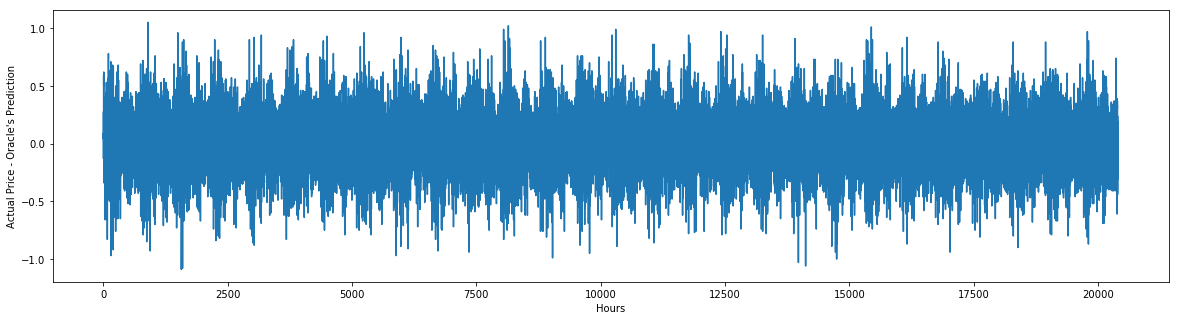

In [4]:
plt.figure(figsize=(20,5))
plt.plot(series)
plt.xlabel('Hours')
plt.ylabel('Actual Price - Oracle\'s Prediction')
plt.show()

### Determining stationarity

/home/abhishek/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/abhishek/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


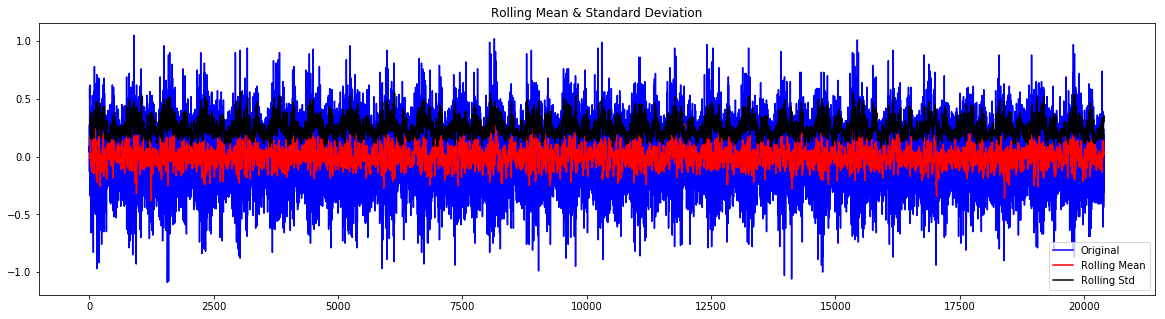

Results of Dickey-Fuller Test:
Test Statistic                   -36.594200
p-value                            0.000000
#Lags Used                        14.000000
Number of Observations Used    20385.000000
Critical Value (1%)               -3.430671
Critical Value (5%)               -2.861682
Critical Value (10%)              -2.566845
dtype: float64


In [5]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(series)

As test statistic is way less than critical value, the series is stationary. For more details refer to third point [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python).

### Determining AR and MA values.

In [6]:
lag_acf = acf(series, nlags=20)
lag_pacf = pacf(series, nlags=20, method='ols')

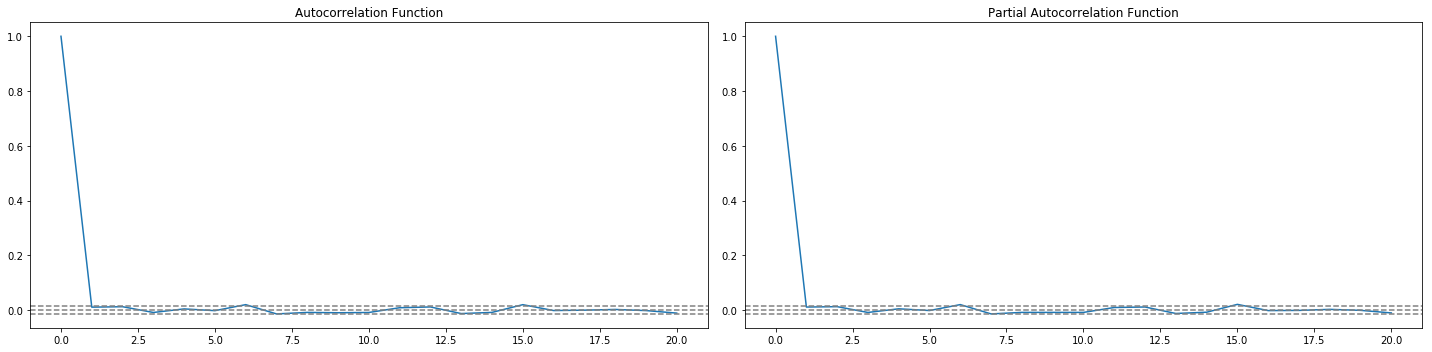

In [7]:
# Plot ACF: 
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

As the lag value where the PACF chart crosses the upper confidence interval for the first time is **2**, p = 2.  
As the lag value where the ACF chart crosses the upper confidence interval for the first time is **2**, q = 2.


For more details refer to the fifth point [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

### Fitting the model

In [8]:
model = ARIMA(series, order=(2,0,2))
model_fit = model.fit()

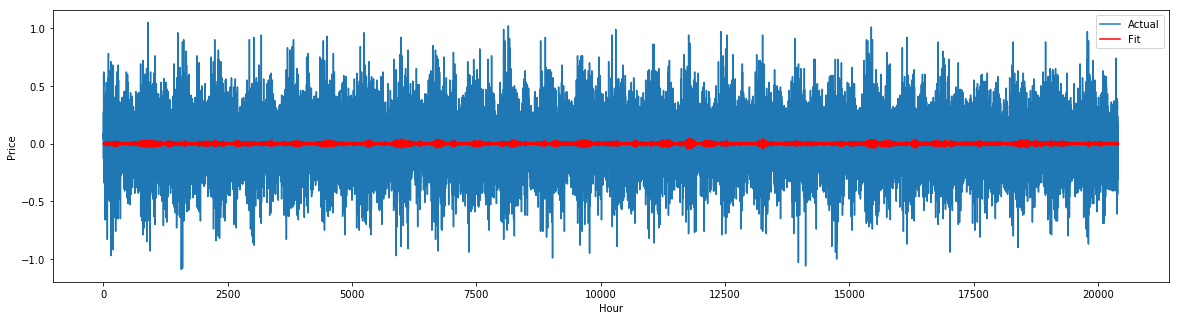

In [9]:
plt.figure(figsize=(20,5))
plt.plot(series, label='Actual')
plt.plot(model_fit.fittedvalues, color='red', label='Fit')
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.show()

As we can see the model does very poorly to predict the time series.

#### Plotting residual errors

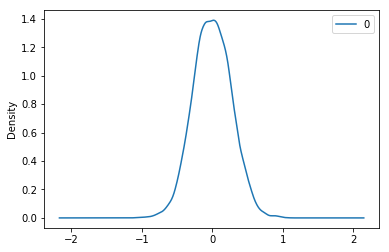

,0
count,2.040000e+04
mean,-1.078681e-07
std,2.719360e-01
min,-1.090654e+00
25%,-1.854305e-01
50%,-3.175711e-03
75%,1.855703e-01
max,1.070046e+00


In [10]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()
residuals.describe()

### Forecasting for next 50 days

In [11]:
price_val_oracle = pd.read_csv('./Processed Data/Price_Val_pred.csv', header=None)
price_val_pred = price_val_oracle + pd.DataFrame(model_fit.predict(20400, 20400 + 50 * 24 - 1).reshape((50, 24)))

### Comparing oracle's prediction with ours

In [12]:
price_val_actual = pd.read_csv('./Processed Data/Price_Val.csv', header=None)

In [13]:
result = pd.concat([pd.DataFrame((price_val_pred - price_val_actual).abs().values.flatten()).describe(), pd.DataFrame((price_val_oracle - price_val_actual).abs().values.flatten()).describe()], axis=1)
result.columns = ['Absolute difference of predicted and actual price', 'Absolute difference of oracle\'s prediction and actual price']

In [14]:
result

,Absolute difference of predicted and actual price,Absolute difference of oracle's prediction and actual price
count,1200.000000,1200.000000
mean,0.227130,0.227125
std,0.166127,0.166143
min,0.000669,0.000000
25%,0.100974,0.100000
50%,0.189579,0.190000
75%,0.320704,0.320000
max,0.940754,0.940000


## Approach 2
* In the training set's actual market price data, we first find the days with minimum market price for **HOUR 1** and denote them by **DAY 1**.
* Now for **DAY 1** to **DAY 31** we find the average market price for each hour.



* In test set's oracle's predicted market price data, we find the corresponding **DAY 1** by finding the day with minimum market price for **HOUR 1**.
* The predicted market price for the following days will be the average market price.

### Determining DAY 1 in actual data

In [15]:
day1_train_actual = list(price_train_actual[0][price_train_actual[0] < 0.8].index)

### Calculating average prices for DAY 1-31

In [16]:
average_price = []
for hour in range(24):
    number_occurence = np.zeros(31)
    sum_day = np.zeros(31)
    for i, j in zip(np.array(day1_train_actual)[:-1], (np.array(day1_train_actual))[1:]):
        sum_day[:j - i] += price_train_actual[hour][i:j].values
        number_occurence[:j - i] += np.ones(j - i)
    average_price.append(sum_day / number_occurence)

In [17]:
average_price = pd.DataFrame(np.array(average_price))

### Determining DAY 1 in oracle's prediction

In [18]:
day1_val_oracle = list(price_val_oracle[0][price_val_oracle[0] < 0.8].index)

### Manually formulating prediction

In [19]:
price_val_pred = pd.concat([average_price[list(range(31))[-1 * day1_val_oracle[0] - 1:-1]], average_price[list(range(31))[:day1_val_oracle[1]-day1_val_oracle[0]]], average_price[list(range(31))[:50-day1_val_oracle[1]]]], axis=1)
price_val_pred.columns = np.arange(50)
price_val_pred = price_val_pred.T

### Comparing oracle's prediction with ours

In [20]:
result = pd.concat([pd.DataFrame((price_val_pred - price_val_actual).abs().values.flatten()).describe(), pd.DataFrame((price_val_oracle - price_val_actual).abs().values.flatten()).describe()], axis=1)
result.columns = ['Absolute difference of predicted and actual price', 'Absolute difference of oracle\'s prediction and actual price']

In [21]:
pd.options.display.float_format = '{:.4f}'.format
result

,Absolute difference of predicted and actual price,Absolute difference of oracle's prediction and actual price
count,1200.0000,1200.0000
mean,0.1678,0.2271
std,0.2345,0.1661
min,0.0000,0.0000
25%,0.0303,0.1000
50%,0.0794,0.1900
75%,0.1923,0.3200
max,1.9875,0.9400
